# Compute time-of-emergence!

Just GISTEMP with the changes in the availability threshold.

### Load functions and packages

In [1]:
import glob
import os

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import regionmask

import cartopy.crs as ccrs

import copy

%matplotlib inline

In [2]:
def sp_map(*nrs, projection = ccrs.PlateCarree(), **kwargs):
    return plt.subplots(*nrs, subplot_kw={'projection':projection}, **kwargs)

## Spatial (5x5 deg.) Data

### Load processed trend data

#### Models

In [3]:
# I need to go from the CAM output variables to the CMOR/CMIP standard names.
pic_tseries_dir = '/glade/work/jonahshaw/trend_uncertainty/nathan/CMIP6_PIC/'
cesm1_dir       = 'CESM1/xagg'
mpi_dir         = 'MPI-GE/xagg'
canesm2_dir     = 'CanESM2/xagg'
esm2m_dir       = 'ESM2M/xagg'

cesm1_cmor_var_dict = {'ts':'TS','tas':'TREFHT','psl':'PSL'}

Take percentiles from PI-Control Runs of models

In [4]:
cesm1_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,cesm1_dir))
mpi_regional_trends_filepath     = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,mpi_dir))
canesm2_regional_trends_filepath = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,canesm2_dir))
esm2m_regional_trends_filepath   = glob.glob('%s/%s/*.1900trends.Percentiles*.nc' % (pic_tseries_dir,esm2m_dir))

Load the trend data.

In [5]:
cesm1_pic_regional_trends_all   = xr.open_dataarray(*cesm1_regional_trends_filepath).chunk({"RegionIndex": 1})
cesm1_pic_regional_trends_all["percentile"] = cesm1_pic_regional_trends_all["percentile"] * 100

mpi_pic_regional_trends_all     = xr.open_dataarray(*mpi_regional_trends_filepath).chunk({"RegionIndex": 1})
mpi_pic_regional_trends_all["percentile"] = mpi_pic_regional_trends_all["percentile"] * 100

canesm2_pic_regional_trends_all = xr.open_dataarray(*canesm2_regional_trends_filepath).chunk({"RegionIndex": 1})
canesm2_pic_regional_trends_all["percentile"] = canesm2_pic_regional_trends_all["percentile"] * 100

esm2m_pic_regional_trends_all   = xr.open_dataarray(*esm2m_regional_trends_filepath).chunk({"RegionIndex": 1})
esm2m_pic_regional_trends_all["percentile"] = esm2m_pic_regional_trends_all["percentile"] * 100

#### Observations

And the OBS-LE is effectively used as a model so I just want the percentiles.

In [6]:
obs_tseries_dir = "/glade/work/jonahshaw/trend_uncertainty/nathan/OBS_LENS/"

gistemp_5x5_95_dir = 'GISTEMP_5x5/20240820/xagg_correctedtime/threshold_0.95/'
gistemp_5x5_70_dir = 'GISTEMP_5x5/20240820/xagg_correctedtime/threshold_0.70/'

In [7]:
gistemp_tas_var = 'tas'

In [8]:
gistemp_5x5_regional_trends_70_filepath = '%s/%s/ensembleChunks_0001_0200.trends.movingstartdate.IPCCRegions.190001-202012.nc' % (obs_tseries_dir,gistemp_5x5_70_dir)
gistemp_5x5_regional_trends_95_filepath = '%s/%s/ensembleChunks_0001_0200.trends.movingstartdate.IPCCRegions.190001-202012.nc' % (obs_tseries_dir,gistemp_5x5_95_dir)

Computed start years

In [9]:
gistemp_5x5_regional_startyears_70_filepath = '%s/%s/ensembleChunks_0001_0200.startyears.IPCCRegions.190001-202012.nc' % (obs_tseries_dir, gistemp_5x5_70_dir)
gistemp_5x5_regional_startyears_95_filepath = '%s/%s/ensembleChunks_0001_0200.startyears.IPCCRegions.190001-202012.nc' % (obs_tseries_dir, gistemp_5x5_95_dir)

Data availability masks

In [10]:
gistemp_5x5_regional_availability_70_filepath = '%s/%s/ensembleChunks_0001_0200.availability.IPCCRegions.190001-202012.nc' % (obs_tseries_dir, gistemp_5x5_70_dir)
gistemp_5x5_regional_availability_95_filepath = '%s/%s/ensembleChunks_0001_0200.availability.IPCCRegions.190001-202012.nc' % (obs_tseries_dir, gistemp_5x5_95_dir)

Load the trend data

In [11]:
gistemp_regional_trends_70_all = xr.open_dataarray(gistemp_5x5_regional_trends_70_filepath).sel(startyear=1).drop_vars(['startyear']).chunk({"RegionIndex": 1})
gistemp_regional_trends_95_all = xr.open_dataarray(gistemp_5x5_regional_trends_95_filepath).sel(startyear=1).drop_vars(['startyear']).chunk({"RegionIndex": 1})

Load the start year data

In [12]:
gistemp_regional_70_startyears = xr.open_dataarray(gistemp_5x5_regional_startyears_70_filepath)
gistemp_regional_95_startyears = xr.open_dataarray(gistemp_5x5_regional_startyears_95_filepath)

Load the availability data

In [13]:
gistemp_regional_70_availability = xr.open_dataarray(gistemp_5x5_regional_availability_70_filepath)
gistemp_regional_95_availability = xr.open_dataarray(gistemp_5x5_regional_availability_95_filepath)

Convert the start years across multiple realizations to the single year used for each data production (see preprocess3.5_obsIPCC_identifystartdate.ipynb)

In [14]:
def process_startyears(
    startyears: xr.DataArray,
    earliest_startyear: int,
    fillvalue: int,
    ens_dim: str = "realization",
):

    startyears_mid = startyears.quantile(0.75, dim=ens_dim)
    
    # Set values less than earliest_startyear to earliest_startyear.
    startyears_final = xr.where(
        startyears_mid > earliest_startyear,
        startyears_mid, 
        earliest_startyear,
    )
    # Revert masking to a nan
    startyears_final = startyears_final.where(startyears_final != fillvalue)
    
    return startyears_final
    

In [15]:
earliest_startyear = 1900
fillvalue = 2100

gistemp_regional_70_startyears = process_startyears(
    gistemp_regional_70_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()

gistemp_regional_95_startyears = process_startyears(
    gistemp_regional_95_startyears,
    earliest_startyear=earliest_startyear,
    fillvalue=fillvalue,
).drop_vars("quantile").squeeze()

Use startyears and availability to mask the trend data before computing ToE

In [16]:
def reindex_time_by_startyear(
    data_ann_avg: xr.DataArray,
    startyears: xr.DataArray,
    stack_vars: list = None,
    spatial_str: str = "z"
):
    """Reindex the temporal dimension so records begin according to a supplied array of start years.

    Args:
        data_ann_avg (xr.DataArray): Annually averaged data with a "year" time dimension.
        startyears (xr.DataArray): Array of start years for the spatial dimensions of the data.
        stack_vars (list, optional): If the spatial dimensions are more than 1, pass them here.. Defaults to None.
        spatial_str (str, optional): Variable to assigned stacked spatial fields. Defaults to "z".

    Returns:
        xr.DataArray: Appropriately reindexed data with new time dimension "recordlength".
    """
    
    # This doesn't work yet but it should eventually.
    if stack_vars is not None:
        data_stacked = data_ann_avg.stack({spatial_str: stack_vars})
        startyears_stacked = startyears.stack({spatial_str: stack_vars})
    else:
        data_stacked = data_ann_avg
        startyears_stacked = startyears

    combino_list = []
    for _spatial_startyear in startyears_stacked:
        time_subset = data_stacked.sel(
            {spatial_str: _spatial_startyear[spatial_str],
             "year": slice(_spatial_startyear, None),
             },
        )

        durations = np.arange(1, time_subset.year.shape[0] + 1)
        
        time_subset = time_subset.rename({"year": "recordlength"}).assign_coords(recordlength=durations)
        combino_list.append(time_subset)

    tseries_indexed_by_duration = xr.combine_nested(
        combino_list,
        concat_dim=[spatial_str],
    )
    if stack_vars is not None:
        # Need to apply the multi-index again for some reason to be able to unstack.
        tseries_indexed_by_duration = tseries_indexed_by_duration.set_index({spatial_str: stack_vars}).unstack(spatial_str)

    return tseries_indexed_by_duration


def mask_trends_by_startyear_and_availability(
    trends: xr.DataArray,
    startyears: xr.DataArray,
    availability: xr.DataArray,
    record_endyear: int=2020,
    stack_vars: list = None,
):

    # Mask all data if startyear is 2019 or 2020
    trends = trends.where(startyears <= record_endyear - 2)
    # Mask duration > 2020 - startyear + 1
    trends = trends.where(trends.duration <= record_endyear - startyears + 1)

    # Apply the availability mask for individual members
    # First convert to the duration time coordinate.
    availability_by_duration = reindex_time_by_startyear(
        availability,
        startyears,
        stack_vars,
    ).rename({"recordlength": "duration"})
    trends = trends.where(availability_by_duration == 1)
    
    return trends

### Compute TTE generally

In [17]:
obs_regional_trend_dict = {
    'GISTEMP_5x5_70': gistemp_regional_trends_70_all,
    'GISTEMP_5x5_95': gistemp_regional_trends_95_all,
}
obs_trend_dict = {
    'regional':obs_regional_trend_dict,
}
obs_regional_startyear_dict = {
    'GISTEMP_5x5_70': gistemp_regional_70_startyears,
    'GISTEMP_5x5_95': gistemp_regional_95_startyears,
}
obs_startyear_dict = {
    'regional':obs_regional_startyear_dict,
}
obs_regional_availability_dict = {
    'GISTEMP_5x5_70': gistemp_regional_70_availability,
    'GISTEMP_5x5_95': gistemp_regional_95_availability,
}
obs_availability_dict = {
    'regional':obs_regional_availability_dict,
}
model_regional_trend_dict = {'CESM1':cesm1_pic_regional_trends_all,
                             'MPI':mpi_pic_regional_trends_all,
                             'CanESM2':canesm2_pic_regional_trends_all,
                             'ESM2M':esm2m_pic_regional_trends_all,
                            }
                                         
model_trend_dict          = {
    'regional':model_regional_trend_dict,
}

Compute the TTE for each ensemble member separately.

In [18]:
def compute_tte(
    obs_trends,
    pic_trends,
    startyears,
    record_endyear: int=2020
):
    '''
    General function comparing the observed trends with the PIC trends to determine TTE.
    '''
    # Can only test up to the longest sampled duration of PI-Control or observations
    duration_limit = np.minimum(obs_trends.duration.max(), pic_trends.duration.max())

    _tte_bool = obs_trends > pic_trends
    _tte      = _tte_bool.duration.where(~_tte_bool).max(dim='duration')
    _tte      = _tte.where(_tte != duration_limit, np.nan) # Mask the unemerged regions
    _tte      = _tte.drop_vars(['percentile'])
    
    _tte      = _tte + startyears
    
    return _tte

In [19]:
def compute_tte_moving_startyear(
    obs_trends,
    pic_trends,
    startyears,
    record_endyear: int=2020
):
    '''
    General function comparing the observed trends with the PIC trends to determine TTE.
    '''
    
    record_mask = obs_trends.duration <= record_endyear - startyears + 1
    
    # Compare obs and pic trends
    _tte_bool = obs_trends > pic_trends
    # Mask out durations outside of the record
    _tte_bool = _tte_bool.where(record_mask)

    _tte      = _tte_bool.duration.where(_tte_bool==0).max(dim='duration')
    _tte      = _tte.drop_vars(['percentile'])
    
    _tte      = _tte + startyears # Convert back to actual year
    _tte      = _tte.where(_tte <= record_endyear) # Detection cannot occur after the record has ended
    
    return _tte

I want to ignore the nan'd data when it means the record has ended.
I have already masked out data that isn't part of the record, but this looks identical to missing data. So regions with startyears post-1900 are just getting a false at the end of things. I would rather chop it off there or use a different filler.

so what if I do the comparison as per usual and then just mask the values that should be ignored with something other than a nan?

__Solution: Operate as usual (first year after last false) but if that year is not in the record mask then set the ToE to nan.__

All models and observations separately.

In [ ]:
spatial_box = []
regional_box = []

all_dict = {}

# Iterate over regional vs. spatial
for _location_type in list(obs_trend_dict.keys()):
    
    print(_location_type)
    _box = spatial_box if (_location_type == 'spatial') else regional_box
    location_box = []
    
    _allobs_trends = obs_trend_dict[_location_type]
    _allobs_startyears = obs_startyear_dict[_location_type]
    _allobs_avail = obs_availability_dict[_location_type]
    _allmodel_trends = model_trend_dict[_location_type]
    
    for _obs_product in list(_allobs_trends.keys()):
        print(_obs_product)
        obs_box = []
        
        _obs_trends = _allobs_trends[_obs_product]
        _obs_startyears = _allobs_startyears[_obs_product]
        _obs_avail = _allobs_avail[_obs_product]
        
        if (_location_type == 'spatial'):
            _stack_vars = ["lat", "lon"]
            _spatial_str = "z"
        else:
            _stack_vars = None #["RegionIndex"]
            _spatial_str = "RegionIndex"
        
        # Mask observations based on individual realization availability.
        availability_by_duration = reindex_time_by_startyear(
            _obs_avail,
            _obs_startyears,
            stack_vars=_stack_vars,
            spatial_str=_spatial_str,
        ).rename({"recordlength": "duration"})
        _obs_trends = _obs_trends.where(availability_by_duration == 1)        
        
        for _model_product in list(_allmodel_trends.keys()):
            print(_model_product)
            _model_trends = _allmodel_trends[_model_product]
            
            # Compute ToE of the median trend (more consistent with using the 50%ile trend for mean)
            _mean_toe = compute_tte_moving_startyear(
                obs_trends=_obs_trends.median(dim='realization'),
                pic_trends=_model_trends.sel(percentile=97.5),
                startyears=_obs_startyears,
            )

            # Compute ToE for each ensemble member and take the 95th percentile
            _strict_toe = compute_tte_moving_startyear(
                obs_trends=_obs_trends,
                pic_trends=_model_trends.sel(percentile=97.5),
                startyears=_obs_startyears,
            )
            _all_toe = _strict_toe.copy().assign_coords({'model':_model_product, 'obs':_obs_product},).expand_dims(['model', "obs"])
            all_dict[_location_type + _obs_product + _model_product] = _all_toe

            # Switch nans to infs in order to compute the strict ToE correctly. Then switch infs back to nans in order to mask correctly.
            _strict_toe = _strict_toe.where(~np.isnan(_strict_toe),np.inf).quantile(q=0.95, dim='realization', method='nearest')
            _strict_toe = _strict_toe.where(~np.isinf(_strict_toe),np.nan)
            
            # Compute the delay and conditional delay mask:
            _delay_toe = _strict_toe - _mean_toe # Compute the delay
            _delay_undef_region = np.bitwise_and(np.isnan(_strict_toe), ~np.isnan(_mean_toe)) # Mask for where tas is emerged in the mean but not the "strict" sense.
            _delay_toe = xr.where(_delay_undef_region, 2020 - _mean_toe, _delay_toe) # Apply the conditional mask
            
            _toes = xr.concat([_mean_toe.assign_coords({'metric':'mean'},).expand_dims(['metric'],axis=[-1]),
                               _strict_toe.assign_coords({'metric':'strict'},).expand_dims(['metric'],axis=[-1]),
                               _delay_toe.assign_coords({'metric':'delay'},).expand_dims(['metric'],axis=[-1]),
                               _delay_undef_region.assign_coords({'metric':'delay_mask'},).expand_dims(['metric'],axis=[-1]),
                              ],
                              dim='metric',
                             )            
                              
            obs_box.append(_toes.assign_coords({'model':_model_product},).expand_dims(['model'],axis=[-1]))
                        
        location_box.append(xr.concat(obs_box,dim='model').assign_coords({'obs':_obs_product},).expand_dims(['obs'],axis=[-1]))
    _box.append(xr.concat(location_box, dim='obs').compute())
    
regional_masked_da = regional_box[0]

regional
GISTEMP_5x5_70
CESM1
MPI
CanESM2
ESM2M
GISTEMP_5x5_95
CESM1
MPI
CanESM2
ESM2M


/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/jonahshaw/conda-envs/py_xagg/lib/python3.12/site-packages/dask/utils.py:78: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


IndexError: list index out of range

In [22]:
all_regional = []
for _key in all_dict:
    
    print(_key)
    if "spatial" in _key:
        all_spatial.append(all_dict[_key]["season"])
    if "regional" in _key:
        _region = all_dict[_key]
        _region.name = "ToE"
        all_regional.append(_region)

all_regional_da = xr.merge(all_regional).compute()      

regionalGISTEMP_5x5_70CESM1
regionalGISTEMP_5x5_70MPI
regionalGISTEMP_5x5_70CanESM2
regionalGISTEMP_5x5_70ESM2M
regionalGISTEMP_5x5_95CESM1
regionalGISTEMP_5x5_95MPI
regionalGISTEMP_5x5_95CanESM2
regionalGISTEMP_5x5_95ESM2M


In [24]:
toe_savedir = "/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/ToE_output"

regional_masked_da.to_netcdf(f"{toe_savedir}/ToE_delay.IPCCRegions.GISTEMP_sensitivity.nc")

all_regional_da.to_netcdf(f"{toe_savedir}/all_ToE.IPCCRegions.GISTEMP_sensitivity.nc")

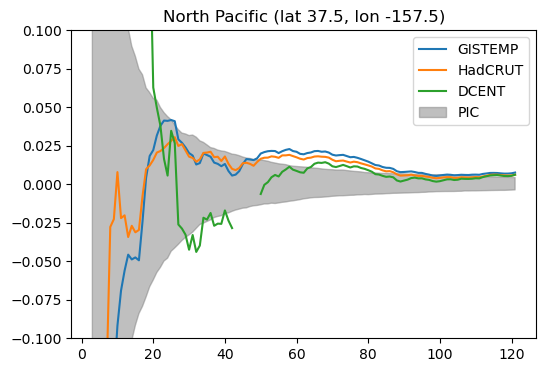

In [28]:
testlat = 37.5
testlon = -157.5

fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(
    gistemp_5x5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    gistemp_5x5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="GISTEMP",
)
ax.plot(
    hadcrut5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    hadcrut5_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="HadCRUT",
)
ax.plot(
    13 + dcent_unfilled_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1).duration,
    dcent_unfilled_spatial_trends_all.sel(lat=testlat, lon=testlon, realization=1),
    label="DCENT",
)

ax.fill_between(
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon).duration,
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon, percentile=2.5),
    cesm1_pic_spatial_trends_all.sel(lat=testlat, lon=testlon, percentile=97.5),
    color="grey",
    label="PIC",
    alpha=0.5
)

ax.set_ylim(-0.1, 0.1)
ax.set_title("North Pacific (lat 37.5, lon -157.5)")

plt.legend()